# Random Forest ML training on MAO-A data set

In [56]:
#Essentials for data handle
import os
import pandas as pd
import numpy as np

#Chemistry data handle
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import mols2grid

#ML essentials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


#ML model-prediction analysis
from matplotlib import pyplot as plt
from pycm import *

#to save final model
import pickle

## Summary of procedure:

- Load data frames from Molecular exploratory analysis (MAO_cluster and MAO_unique)
- Divide by strong and weak binding and set labels accordingly
- Save SMILES data with labels and obtain Vector descriptors using Morgan Fingerprints with RDkit
- Split train and test sets and train Rando Forest model.
- Compare both trainings from both dataframes


In [6]:
#load file

url_MAO_cluster = 'https://raw.githubusercontent.com/montserratamion/ChemInformatics_MAO-A/main/1_Exploratory_Analysis/MAO-A_cluster.csv'
url_MAO_unique = 'https://raw.githubusercontent.com/montserratamion/ChemInformatics_MAO-A/main/1_Exploratory_Analysis/MAO-A_cluster_unique.csv'

MAO_cluster_df = pd.read_csv(url_MAO_cluster, sep=',')
MAO_unique_df = pd.read_csv(url_MAO_unique, sep=',')
MAO_cluster_df.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count,Cluster
0,CHEMBL3660741,CS(=O)(=O)Nc1ccc(-c2coc3cc(C#CC4CN(C(=O)CO)C4)...,IC50,'>',130000.0,nM,452.104207,1.6337,2,8,6,True,4,1
1,CHEMBL3660745,CC(O)C(=O)N1CC(C#Cc2ccc3c(=O)c(-c4ccc(NS(C)(=O...,IC50,'>',130000.0,nM,466.119857,2.0222,2,8,6,True,4,1
2,CHEMBL3660734,CS(=O)(=O)Nc1ccc(-c2coc3cc(C#CC4CNC4)ccc3c2=O)cc1,IC50,'>',130000.0,nM,394.098728,2.4024,2,6,6,True,4,1
3,CHEMBL3660743,CC(C)(O)C(=O)N1CC(C#Cc2ccc3c(=O)c(-c4ccc(NS(C)...,IC50,'>',130000.0,nM,480.135507,2.4123,2,8,6,True,4,1
4,CHEMBL3660740,CN(C)CCC(=O)N1CC(C#Cc2ccc3c(=O)c(-c4ccc(NS(C)(...,IC50,'=',46947.0,nM,493.167142,2.5931,1,8,6,True,4,1


In [8]:
MAO_cluster_df.shape

(3158, 14)

In [7]:
MAO_unique_df.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count,Cluster
0,CHEMBL3660741,CS(=O)(=O)Nc1ccc(-c2coc3cc(C#CC4CN(C(=O)CO)C4)...,IC50,'>',130000.00,nM,452.104207,1.63370,2,8,6,True,4,1
1,CHEMBL508324,C[C@@H]1CCCC/C1=N/Nc1nc(-c2ccc(C#N)cc2)cs1,IC50,'=',5495.41,nM,310.125218,4.65978,1,4,6,True,4,2
2,CHEMBL399572,N#Cc1ccc(-c2csc(NN=C3CCCC3)n2)cc1,IC50,'=',644.00,nM,282.093917,4.02368,1,4,6,True,4,3
3,CHEMBL3818992,O=C(/C=C/c1ccc(O)c(O)c1)NCCC1CCN(Cc2ccccc2)CC1,IC50,'=',3500.00,nM,380.209993,3.52950,3,5,6,True,4,4
4,CHEMBL3629466,COc1ccc(/C=C/c2cc(OC)cc(OC)c2/C=C/C(=O)c2cc3cc...,IC50,'=',41700.00,nM,468.157288,5.88530,0,6,6,False,3,5


In [11]:
MAO_unique_df.shape

(1605, 14)

## Obtaining descriptors for both dataframes

In [16]:
# Classify the data in strong or weak binding and add labels
# Strong binding -> label =1
# Weak binding -> label = 0

# MAO_cluster_df
    #select strong and weak binding molecules
strong_cluster = MAO_cluster_df.loc[MAO_cluster_df['Standard Value']<=500]
weak_cluster = MAO_cluster_df.loc[MAO_cluster_df['Standard Value']>=2000]
    #add labels
strong_cluster = strong_cluster.assign(label=1)
weak_cluster = weak_cluster.assign(label=0)
    #Combine strong and weak dataframe
combined_cluster = pd.concat([strong_cluster, weak_cluster], axis=0)


#MAO_unique_df
    #select strong and weak binding molecules
strong_unique = MAO_unique_df.loc[MAO_unique_df['Standard Value']<=500]
weak_unique = MAO_unique_df.loc[MAO_unique_df['Standard Value']>=2000]
    #add labels
strong_unique = strong_unique.assign(label=1)
weak_unique = weak_unique.assign(label=0)
    #Combine strong and weak dataframe
combined_unique = pd.concat([strong_unique, weak_unique], axis=0)

In [17]:
combined_cluster.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count,Cluster,label
131,CHEMBL4163558,Cc1c2c(nn1-c1ccc(/C=N/NC(=S)Nc3cccc(F)c3)cc1)-...,IC50,'=',470.0,nM,520.115144,4.44582,2,8,6,False,3,7,1
134,CHEMBL4161420,Cc1ccc(NC(=S)N/N=C/c2ccc(-n3nc4c(c3C)N(C)S(=O)...,IC50,'=',3.0,nM,516.140216,4.61514,2,8,6,False,3,7,1
135,CHEMBL4169343,Cc1ccccc1NC(=S)N/N=C/c1ccc(-n2nc3c(c2C)N(C)S(=...,IC50,'=',10.0,nM,516.140216,4.61514,2,8,6,False,3,7,1
137,CHEMBL4174892,Cc1cccc(C)c1NC(=S)N/N=C/c1ccc(-n2nc3c(c2C)N(C)...,IC50,'=',10.0,nM,530.155866,4.92356,2,8,6,False,3,7,1
157,CHEMBL5195988,O=C1c2ccccc2-c2nccc3cc(OCCCN4CCN(c5ccccc5)CC4)...,IC50,'=',9.0,nM,449.210327,5.03730,0,5,6,False,3,9,1


In [18]:
combined_cluster.tail()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count,Cluster,label
2973,CHEMBL3218160,C(=N/Nc1nc(-c2ccc3ccccc3c2)cs1)\c1ccco1,IC50,'=',2040.0,nM,319.077933,5.0023,1,4,6,False,3,1421,0
2974,CHEMBL2332211,C#CCN(C)[C@H](CF)CC(=C)C,IC50,'>',2000.0,nM,169.126678,1.8557,0,1,0,True,4,1422,0
2975,CHEMBL2332210,C#CCN(C)[C@H](CF)CC(C)C,IC50,'>',2000.0,nM,171.142328,1.9356,0,1,0,True,4,1423,0
2976,CHEMBL2332212,C#CCN(C)[C@H](CF)Cc1ccco1,IC50,'>',2000.0,nM,195.105942,1.7252,0,2,5,True,4,1424,0
2977,CHEMBL1911928,C#CCN(C)[C@H](CF)Cc1ccccc1,IC50,'>',2000.0,nM,205.126678,2.1322,0,1,6,True,4,1425,0


In [19]:
combined_cluster.shape

(2817, 15)

In [20]:
combined_unique.shape

(1459, 15)

- MAO_cluster_df was reduced from 3158 to 2817 molecule entries
- MAO_unique_df was reduced from 1605 to 1459 molecule entries

In [21]:
#Saving new clean datasets and save SMILES codes with labels

# MAO_cluster_df

combined_cluster.to_csv('MAO-A_cluster_cleaned.csv', index=None)
combined_cluster[['SMILES', 'label']].to_csv('MAO-A_cluster.smi', sep='\t', header=False, index=None)

#MAO_unique_df

combined_unique.to_csv('MAO-A_unique_cleaned.csv', index=None)
combined_unique[['SMILES', 'label']].to_csv('MAO-A_unique.smi', sep='\t', header=False, index=None)

## Obtaining structural features from SMILE codes using RDkit

- Morgan Fingerprints (extended conectivity fingerprints)

In [22]:
# Loading SMILES data to calculate Morgan Fingerprints

MAO_smi_cluster = Chem.SmilesMolSupplier('MAO-A_cluster.smi', delimiter='\t', titleLine=False)

MAO_smi_unique = Chem.SmilesMolSupplier('MAO-A_unique.smi', delimiter='\t', titleLine=False)

In [26]:
#Calculation of Morgan fingerprints and converting them in Numpy array matrix

# MAO_cluster
MAO_fp_cluster = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in MAO_smi_cluster if mol is not None]
MAO_train_cluster = np.asarray(MAO_fp_cluster,dtype=np.int32)

# MAO_unique
MAO_fp_unique = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in MAO_smi_unique if mol is not None]
MAO_train_unique = np.asarray(MAO_fp_unique,dtype=np.int32)

In [28]:
MAO_train_cluster 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int32)

In [37]:
#Adding the labels to the molecule vector matrices

# MAO_cluster
ids_cluster = [mol.GetProp('_Name') for mol in MAO_smi_cluster if mol is not None]
labels_cluster = np.asarray(ids_cluster, dtype=np.int32).reshape(-1,1)

# MAO_unique

ids_unique = [mol.GetProp('_Name') for mol in MAO_smi_unique if mol is not None]
labels_unique = np.asarray(ids_unique, dtype=np.int32).reshape(-1,1)

In [39]:
# Concatenate fingerprints with labels arrays

# MAO_cluster

MAO_dataset_cluster = np.concatenate([MAO_train_cluster, labels_cluster], axis=1)

# MAO_unique

MAO_dataset_unique = np.concatenate([MAO_train_unique, labels_unique], axis=1)

In [41]:
# Saving the features

# MAO_cluster

np.save('MAO-A_cluster_features', MAO_dataset_cluster)

# MAO_unique

np.save('MAO-A_unique_features', MAO_dataset_unique)

## Building Random Forest ML model using Sklearn

Summary:

- Divide datasets for training and testing
- Perform training (RandomForestClassifier)
- Make predictions
- Evaluate prediction (confusion matrix descriptors)
- Compare training with both data sets (cluster and unique MAO-A datasets)

In [43]:
#Spliting datasets using sklearn.train_test_split

# MAO_cluster
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(MAO_train_cluster, labels_cluster, test_size=0.25, random_state=42, shuffle=True)

# MAO_unique
X_train_unique, X_test_unique, y_train_unique, y_test_unique = train_test_split(MAO_train_unique, labels_unique, test_size=0.25, random_state=42, shuffle=True)



In [44]:
X_train_cluster.shape

(2112, 2048)

In [45]:
X_test_cluster.shape

(705, 2048)

In [46]:
X_train_unique.shape

(1094, 2048)

In [47]:
X_test_unique.shape

(365, 2048)

- MAO_cluster datasets:

                    - train : 2112
                    - test  : 705

- MAO_unique datasets:

                    - train : 1094
                    - test  : 365


In [49]:
# MAO_cluster

# Random Forest Model training
rf_cluster = RandomForestClassifier(random_state=42)
rf_cluster.fit(X_train_cluster, y_train_cluster.ravel())

#prediction
predicted_cluster = rf_cluster.predict(X_test_cluster)

#ROC AUC score
roc_auc_score(y_test_cluster, predicted_cluster)

0.7293127493898424

In [50]:
# MAO_unique

# Random Forest Model training
rf_unique = RandomForestClassifier(random_state=42)
rf_unique.fit(X_train_unique, y_train_unique.ravel())

#prediction
predicted_unique = rf_unique.predict(X_test_unique)

#ROC AUC score
roc_auc_score(y_test_unique, predicted_unique)

0.6323529411764706

In [57]:
#prediction analysis

cm_cluster = ConfusionMatrix(y_test_cluster.reshape(-1), predicted_cluster)
cm_unique = ConfusionMatrix(y_test_unique.reshape(-1), predicted_unique)
#print(cm_cluster)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

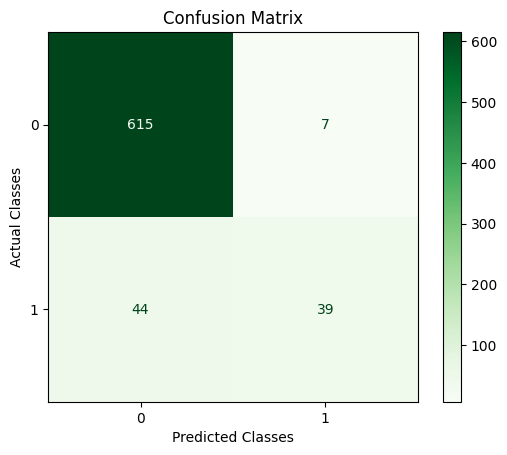

In [55]:
cm_cluster.plot(cmap=plt.cm.Greens, number_label=True, plot_lib="matplotlib")

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

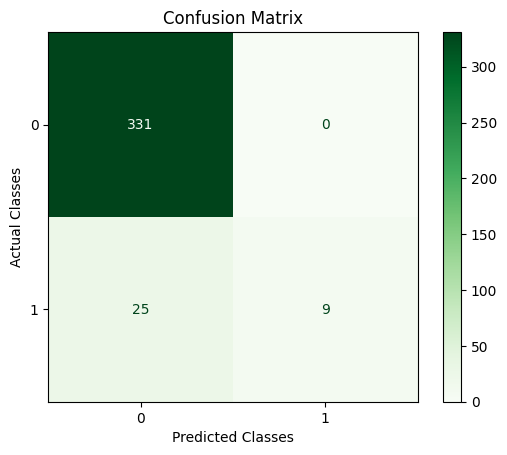

In [58]:
cm_unique.plot(cmap=plt.cm.Greens, number_label=True, plot_lib="matplotlib")

In [53]:
#Save models with Pickle

# MAO_unique
with open('rf_model_MAO-A_cluster.pkl', 'wb') as f:
    pickle.dump(rf_cluster, f)

# MAO_unique   
with open('rf_model_MAO-A_unique.pkl', 'wb') as f:
    pickle.dump(rf_unique, f)